In [1]:
import os, glob
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import time
import os.path as path
from tensorflow import keras
import keras
import keras.backend as K

from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D, Activation

import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import pickle
import numpy as np
from imutils import paths
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [2]:

np.random.seed(2023)

MODEL_NAME = 'hindi_convnet'
EPOCHS = 150
BATCH_SIZE = 16 
CHANNELS = 1
num_classes = 5
img_height = 32
img_width = 32

In [3]:
def load_data(datasetPath):

    # load data from the pickle file
    with open(datasetPath, 'rb') as f:
        data, labels = pickle.load(f)


    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    print("\n[INFO] splitting dataset into train and validation sets")
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22)

    print("\n[INFO] reshaping images")
    x_train = x_train.reshape(x_train.shape[0], img_height, img_width, CHANNELS)
    x_test = x_test.reshape(x_test.shape[0], img_height, img_width, CHANNELS)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return x_train, y_train, x_test, y_test



In [4]:
def build_model_1(MODEL_NAME):
    print("\n[INFO] creating model")
    model = Sequential()
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=(img_height, img_width, CHANNELS)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(50, (5, 5), padding="same", input_shape=(img_height, img_width, CHANNELS)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(100, (5, 5), padding="same", input_shape=(img_height, img_width, CHANNELS)))
    model.add(Activation("relu"))
    model.add(MaxPoolingx2D(pool_size=(2, 2), strides=(20, 2)))

    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()
    return model



In [5]:
def build_model_2(MODEL_NAME):
    print("\n[INFO] creating model")
    model = Sequential()

    chanDim  = 1
    # first CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(img_height, img_width, CHANNELS)))
#     model.add(BatchNormalization(axis=chanDim))
    
#     model.add(Conv2D(32, (5, 5), padding="same"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3),  activation='relu', padding="same"))
    model.add(BatchNormalization(axis=chanDim))
        
    model.add(Conv2D(64, (3, 3),  activation='relu', padding="same"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Dropout(0.25))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(64))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes,activation='softmax'))
    
    return model

In [6]:
def LeNet5():
    model=Sequential()
    
    model.add(Conv2D(6,kernel_size=(5,5),strides=(1,1),activation='relu',input_shape=(img_height,img_width,CHANNELS),padding='same'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    
    model.add(Dense(84, activation='relu'))
    
    model.add(Dense(5, activation='softmax'))
    
    model.summary()
    return model

In [7]:
def ANN():
    model = Sequential() # declare model
    model.add(Dense(784, input_shape=(img_height*img_width,CHANNELS ), kernel_initializer='he_normal')) # first layer
    model.add(Activation('relu'))


    # Fill in Model Here
#     kernel initializer = random_normal, he_normal
#     activation function = relu, selu, tanh, sigmoid
    model.add(Dense(500, activation='relu', kernel_initializer='he_normal'))
#     model.add(Activation('tanh'))

    model.add(Dense(200, kernel_initializer='he_normal'))
    model.add(Activation('relu'))

    model.add(Dense(100, kernel_initializer='he_normal'))
    model.add(Activation('tanh'))

    #-----------------------------------------------------------------------------

    model.add(Dense(num_classes, kernel_initializer='he_normal')) # last layer
#     model.add(Activation('softmax'))
#     model.add(Dense(num_classes,activation='softmax'))
    
    model.summary()
    
    return  model

In [8]:
def plot_model_history(model_history,MODEL_NAME):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # print(model_history.history.keys())
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
#     print(np.arange(1,len(model_history.history['accuracy'])+1,10),np.arange(1,len(model_history.history['accuracy'])+1,10))
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+10,10),np.arange(1,len(model_history.history['accuracy'])+10,10))
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+10,10),np.arange(1,len(model_history.history['loss'])+10,10))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    fig.savefig(f'./Model_graph/{MODEL_NAME}.png')



In [9]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)


In [18]:
def train(model, x_train, y_train, x_test, y_test,MODEL_NAME):

    print("\n[INFO] model training starting\n")    
    model.compile(loss=keras.losses.categorical_crossentropy, \
                  optimizer=keras.optimizers.Adam(), \
                  metrics=['accuracy'])


    # start timer
    start = time.time()

    # checkpoint
    outputFolder = f'./output-checkpoint/{MODEL_NAME}'
    if not os.path.exists(outputFolder):
        os.makedirs(outputFolder)

    filepath = outputFolder + "/weights-{epoch:02d}-{val_acc:.2f}.h5py"

    epoch_num = 50
    file_ini = outputFolder + '/weights-' + str(epoch_num) + '*'
    filename =  glob.glob(file_ini)
    K.set_value(model.optimizer.learning_rate, 0.0001)
    # checkpoint creation for saving model
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, \
                            save_best_only=False, save_weights_only=True, \
                            mode='auto', period=10)

    # tensorboard logs for visualization
    tbCallBack = TensorBoard(log_dir='./logs', batch_size=BATCH_SIZE, \
                write_grads=True, histogram_freq=2, write_graph=True, write_images=True)

    # define early stopping callback
    earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
    
    model_info = model.fit(x_train, y_train, \
            batch_size=BATCH_SIZE, \
            epochs=EPOCHS, \
            verbose=1, \
            validation_data=(x_test, y_test) , \
            callbacks=[tbCallBack])
    
    # end timer and print the time taken to train model
    end = time.time()
    print("\nModel took %0.2f seconds to train"%(end - start))
    # joblib.dump(model_info,'model.pkl')
    # display graph accuracy and loss
    plot_model_history(model_info,MODEL_NAME)

    # compute test accuracy
    acc=accuracy(x_test, y_test, model)
    print("Accuracy on test data is: %0.2f"%acc)
    return acc




In [11]:
def export_model(model, input_node_names, output_node_name,MODEL_NAME):
    # Save trained model in .h5py file
    print("\n[INFO] exporting model to .h5py file")
#     if not path.exists(f'out/{MODEL_NAME}/hhrc_nn.h5py'):
#         print("\n[info] out folder not available, creating folder 'out' in the root directory")
#         os.mkdir(f'out/{MODEL_NAME}')
#     model.save_weights(f'out/{MODEL_NAME}/hhrc_nn.h5py')
    model.save(f"out/{MODEL_NAME}-{BATCH_SIZE}-{EPOCHS}.h5")
    # model.predict()
    # print("\n[INFO] exporting model to .pb file\n")
    # tf.train.write_graph(K.get_session().graph_def, 'out', \
    #     MODEL_NAME + '_graph.pbtxt')

    # # saver.save(K.get_session(), 'out/' + MODEL_NAME + '.chkp')

#     freeze_graph.freeze_graph(f'out/{MODEL_NAME}/' + MODEL_NAME + '_graph.pbtxt', None, \
#         False, f'out/{MODEL_NAME}/' + MODEL_NAME + '.chkp', output_node_name, \
#         "save/restore_all", "save/Const:0", \
#         f'out/{MODEL_NAME}/frozen_' + MODEL_NAME + '.pb', True, "")

#     input_graph_def = tf.GraphDef()
#     with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
#         input_graph_def.ParseFromString(f.read())

#     output_graph_def = optimize_for_inference_lib.optimize_for_inference(
#             input_graph_def, input_node_names, [output_node_name],
#             tf.float32.as_datatype_enum)

#     with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
#         f.write(output_graph_def.SerializeToString())

    print("\n[INFO] model saved")



In [12]:
def cnn_laye():
    MODEL_NAME='CNN_Layer_10'
    model=build_model_1(MODEL_NAME)
    if not path.exists(f'out\\{MODEL_NAME}'):
        print("\n[info] out folder not available, creating folder 'out' in the root directory")
        os.mkdir(f'out\\{MODEL_NAME}')
    acc=train(model, x_train, y_train, x_test, y_test,MODEL_NAME)
    Accuracy[MODEL_NAME]=acc
    export_model(model, ["conv2d_1_input"], "dense2/Softmax",MODEL_NAME)

In [13]:
def cnn_layer_22():
    MODEL_NAME='CNN_Layer_22'
    model=build_model_2(MODEL_NAME)
    if not path.exists(f'out\\{MODEL_NAME}'):
        print("\n[info] out folder not available, creating folder 'out' in the root directory")
        os.mkdir(f'out\\{MODEL_NAME}')
    acc=train(model, x_train, y_train, x_test, y_test,MODEL_NAME)
    Accuracy[MODEL_NAME]=acc
    export_model(model, ["conv2d_1_input"], "dense2/Softmax",MODEL_NAME)

In [14]:
def Lenetmodel():
    MODEL_NAME='LeNET-5'
    model=LeNet5()
    if not path.exists(f'out\\{MODEL_NAME}'):
        print("\n[info] out folder not available, creating folder 'out' in the root directory")
        os.mkdir(f'out\\{MODEL_NAME}')
    acc=train(model, x_train, y_train, x_test, y_test,MODEL_NAME)
    Accuracy[MODEL_NAME]=acc
    export_model(model, ["conv2d_1_input"], "dense2/Softmax",MODEL_NAME)

In [15]:
def ANN_model():
    MODEL_NAME='ANN'
    model=ANN()
    if not path.exists(f'out\\{MODEL_NAME}'):
        print("\n[info] out folder not available, creating folder 'out' in the root directory")
        os.mkdir(f'out\\{MODEL_NAME}')
    acc=train(model, x_train, y_train, x_test, y_test,MODEL_NAME)
    Accuracy[MODEL_NAME]=acc
    export_model(model, ["conv2d_1_input"], "dense2/Softmax",MODEL_NAME)

In [16]:
def train_ANN(model,x_train,x_test,y_train,y_test,MODEL_NAME):
    model.compile(optimizers)


[INFO] loading data from the dataset into variables

[INFO] splitting dataset into train and validation sets

[INFO] reshaping images

[INFO] creating model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 20)        520       
                                                                 
 activation_4 (Activation)   (None, 32, 32, 20)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 20)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 20)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 50)        25050     
                            

54/54 [==============================] - 4s 81ms/step - loss: 1.0229 - accuracy: 0.6087 - val_loss: 1.0530 - val_accuracy: 0.5822
Epoch 36/150
54/54 [==============================] - 4s 65ms/step - loss: 1.0083 - accuracy: 0.6275 - val_loss: 1.0107 - val_accuracy: 0.6056
Epoch 37/150
54/54 [==============================] - 4s 74ms/step - loss: 0.9767 - accuracy: 0.6251 - val_loss: 0.9838 - val_accuracy: 0.6526
Epoch 38/150
54/54 [==============================] - 3s 64ms/step - loss: 0.9612 - accuracy: 0.6381 - val_loss: 0.9645 - val_accuracy: 0.6714
Epoch 39/150
54/54 [==============================] - 4s 75ms/step - loss: 0.9420 - accuracy: 0.6381 - val_loss: 0.9279 - val_accuracy: 0.6854
Epoch 40/150
54/54 [==============================] - 3s 65ms/step - loss: 0.9299 - accuracy: 0.6463 - val_loss: 0.9082 - val_accuracy: 0.6948
Epoch 41/150
54/54 [==============================] - 4s 75ms/step - loss: 0.9012 - accuracy: 0.6616 - val_loss: 0.9097 - val_accuracy: 0.6901
Epoch 42/150

54/54 [==============================] - 3s 63ms/step - loss: 0.2600 - accuracy: 0.9119 - val_loss: 0.2911 - val_accuracy: 0.9155
Epoch 93/150
54/54 [==============================] - 4s 75ms/step - loss: 0.2720 - accuracy: 0.9154 - val_loss: 0.2976 - val_accuracy: 0.9014
Epoch 94/150
54/54 [==============================] - 3s 63ms/step - loss: 0.2769 - accuracy: 0.8989 - val_loss: 0.2966 - val_accuracy: 0.9202
Epoch 95/150
54/54 [==============================] - 4s 69ms/step - loss: 0.2607 - accuracy: 0.9213 - val_loss: 0.3053 - val_accuracy: 0.8967
Epoch 96/150
54/54 [==============================] - 3s 64ms/step - loss: 0.2358 - accuracy: 0.9236 - val_loss: 0.3053 - val_accuracy: 0.9014
Epoch 97/150
54/54 [==============================] - 4s 71ms/step - loss: 0.2456 - accuracy: 0.9130 - val_loss: 0.3149 - val_accuracy: 0.8920
Epoch 98/150
54/54 [==============================] - 3s 64ms/step - loss: 0.2357 - accuracy: 0.9224 - val_loss: 0.2823 - val_accuracy: 0.9108
Epoch 99/150

54/54 [==============================] - 4s 72ms/step - loss: 0.0975 - accuracy: 0.9765 - val_loss: 0.2400 - val_accuracy: 0.9155
Epoch 150/150
54/54 [==============================] - 3s 63ms/step - loss: 0.0840 - accuracy: 0.9765 - val_loss: 0.2771 - val_accuracy: 0.9108

Model took 553.66 seconds to train


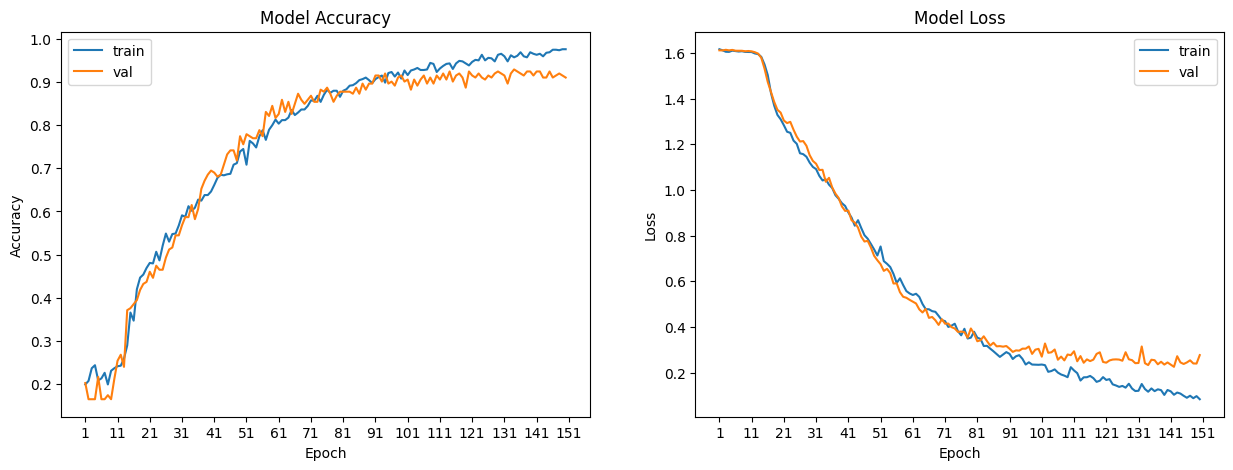

7/7 [==============================] - 1s 32ms/step
Accuracy on test data is: 91.08

[INFO] exporting model to .h5py file

[INFO] model saved

[INFO] creating model


C:\Users\sharm\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



[info] out folder not available, creating folder 'out' in the root directory

[INFO] model training starting

Epoch 1/150
54/54 [==============================] - 15s 215ms/step - loss: 2.2742 - accuracy: 0.2280 - val_loss: 1.7774 - val_accuracy: 0.1972
Epoch 2/150
54/54 [==============================] - 8s 143ms/step - loss: 2.1778 - accuracy: 0.2197 - val_loss: 2.0686 - val_accuracy: 0.2770
Epoch 3/150
54/54 [==============================] - 10s 194ms/step - loss: 2.0630 - accuracy: 0.2421 - val_loss: 2.0818 - val_accuracy: 0.2770
Epoch 4/150
54/54 [==============================] - 8s 140ms/step - loss: 2.0088 - accuracy: 0.2479 - val_loss: 2.0423 - val_accuracy: 0.2300
Epoch 5/150
54/54 [==============================] - 10s 184ms/step - loss: 1.8958 - accuracy: 0.2679 - val_loss: 2.1612 - val_accuracy: 0.2254
Epoch 6/150
54/54 [==============================] - 8s 141ms/step - loss: 1.7933 - accuracy: 0.3126 - val_loss: 2.1708 - val_accuracy: 0.2347
Epoch 7/150
54/54 [=========

54/54 [==============================] - 7s 136ms/step - loss: 0.2776 - accuracy: 0.9130 - val_loss: 0.2546 - val_accuracy: 0.9155
Epoch 55/150
54/54 [==============================] - 10s 186ms/step - loss: 0.2637 - accuracy: 0.9213 - val_loss: 0.2735 - val_accuracy: 0.8967
Epoch 56/150
54/54 [==============================] - 7s 139ms/step - loss: 0.2640 - accuracy: 0.9189 - val_loss: 0.3663 - val_accuracy: 0.8638
Epoch 57/150
54/54 [==============================] - 10s 188ms/step - loss: 0.2689 - accuracy: 0.9166 - val_loss: 0.2647 - val_accuracy: 0.9343
Epoch 58/150
54/54 [==============================] - 7s 139ms/step - loss: 0.2659 - accuracy: 0.9177 - val_loss: 0.2690 - val_accuracy: 0.9202
Epoch 59/150
54/54 [==============================] - 10s 183ms/step - loss: 0.2398 - accuracy: 0.9318 - val_loss: 0.2621 - val_accuracy: 0.9202
Epoch 60/150
54/54 [==============================] - 7s 134ms/step - loss: 0.2090 - accuracy: 0.9436 - val_loss: 0.2658 - val_accuracy: 0.9108
Ep

Epoch 111/150
54/54 [==============================] - 10s 183ms/step - loss: 0.1004 - accuracy: 0.9765 - val_loss: 0.1947 - val_accuracy: 0.9249
Epoch 112/150
54/54 [==============================] - 7s 137ms/step - loss: 0.0993 - accuracy: 0.9730 - val_loss: 0.2430 - val_accuracy: 0.9108
Epoch 113/150
54/54 [==============================] - 10s 179ms/step - loss: 0.0867 - accuracy: 0.9753 - val_loss: 0.2276 - val_accuracy: 0.9390
Epoch 114/150
54/54 [==============================] - 7s 136ms/step - loss: 0.0928 - accuracy: 0.9753 - val_loss: 0.2004 - val_accuracy: 0.9343
Epoch 115/150
54/54 [==============================] - 10s 182ms/step - loss: 0.0964 - accuracy: 0.9753 - val_loss: 0.1931 - val_accuracy: 0.9343
Epoch 116/150
54/54 [==============================] - 7s 137ms/step - loss: 0.0799 - accuracy: 0.9871 - val_loss: 0.2118 - val_accuracy: 0.9390
Epoch 117/150
54/54 [==============================] - 10s 185ms/step - loss: 0.0781 - accuracy: 0.9859 - val_loss: 0.1971 - va

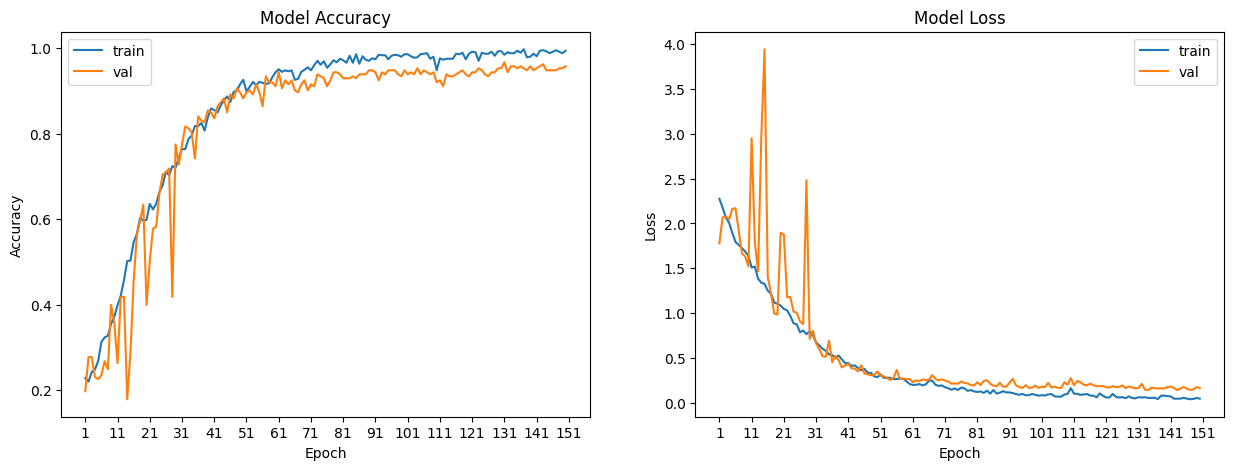

7/7 [==============================] - 1s 57ms/step
Accuracy on test data is: 95.77

[INFO] exporting model to .h5py file

[INFO] model saved
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 6)         156       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 16)        2416      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 6, 6, 16)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 576)    

54/54 [==============================] - 1s 21ms/step - loss: 0.5850 - accuracy: 0.8108 - val_loss: 0.8508 - val_accuracy: 0.6948
Epoch 43/150
54/54 [==============================] - 2s 29ms/step - loss: 0.5754 - accuracy: 0.8108 - val_loss: 0.8066 - val_accuracy: 0.7136
Epoch 44/150
54/54 [==============================] - 1s 21ms/step - loss: 0.5776 - accuracy: 0.8202 - val_loss: 0.7612 - val_accuracy: 0.7230
Epoch 45/150
54/54 [==============================] - 1s 27ms/step - loss: 0.5835 - accuracy: 0.8120 - val_loss: 0.7551 - val_accuracy: 0.7230
Epoch 46/150
54/54 [==============================] - 1s 21ms/step - loss: 0.5387 - accuracy: 0.8367 - val_loss: 0.8011 - val_accuracy: 0.7042
Epoch 47/150
54/54 [==============================] - 2s 28ms/step - loss: 0.5622 - accuracy: 0.8120 - val_loss: 0.7622 - val_accuracy: 0.7277
Epoch 48/150
54/54 [==============================] - 1s 21ms/step - loss: 0.5221 - accuracy: 0.8284 - val_loss: 0.7386 - val_accuracy: 0.7512
Epoch 49/150

54/54 [==============================] - 2s 28ms/step - loss: 0.1804 - accuracy: 0.9671 - val_loss: 0.4438 - val_accuracy: 0.8357
Epoch 100/150
54/54 [==============================] - 1s 21ms/step - loss: 0.1816 - accuracy: 0.9624 - val_loss: 0.4534 - val_accuracy: 0.8451
Epoch 101/150
54/54 [==============================] - 1s 28ms/step - loss: 0.1773 - accuracy: 0.9589 - val_loss: 0.4495 - val_accuracy: 0.8498
Epoch 102/150
54/54 [==============================] - 1s 21ms/step - loss: 0.1692 - accuracy: 0.9636 - val_loss: 0.4894 - val_accuracy: 0.8263
Epoch 103/150
54/54 [==============================] - 1s 28ms/step - loss: 0.1620 - accuracy: 0.9647 - val_loss: 0.4334 - val_accuracy: 0.8545
Epoch 104/150
54/54 [==============================] - 1s 21ms/step - loss: 0.1526 - accuracy: 0.9659 - val_loss: 0.4240 - val_accuracy: 0.8592
Epoch 105/150
54/54 [==============================] - 2s 28ms/step - loss: 0.1563 - accuracy: 0.9659 - val_loss: 0.4404 - val_accuracy: 0.8498
Epoch 

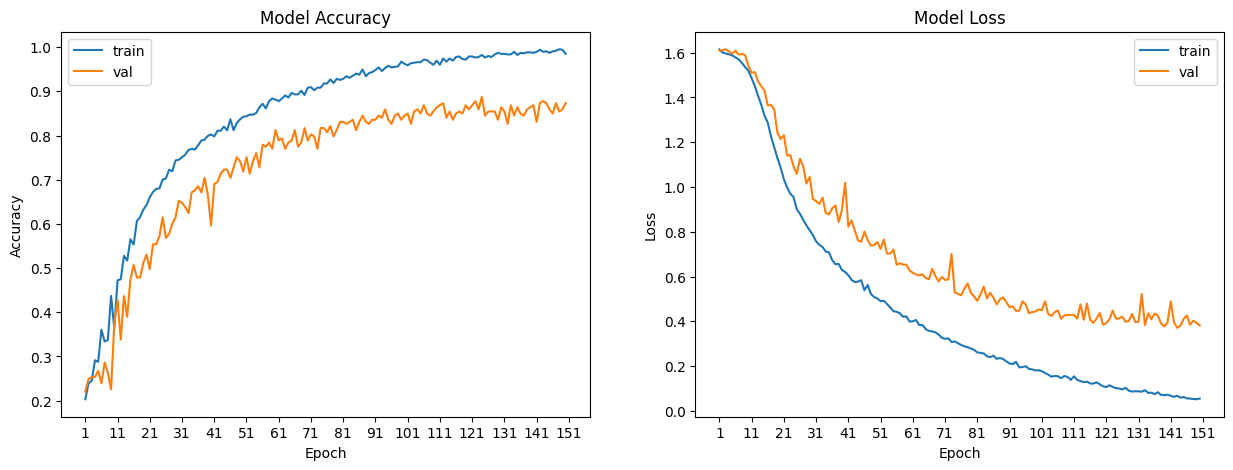

7/7 [==============================] - 0s 12ms/step
Accuracy on test data is: 87.32

[INFO] exporting model to .h5py file

[INFO] model saved


In [19]:
# def main():
Accuracy=dict()

print("\n[INFO] loading data from the dataset into variables")
x_train, y_train, x_test, y_test = load_data("D:\Programming\HHCR testing\dataset_pickles\dataset_classes.pickle")
cnn_layer_10()
cnn_layer_22()
Lenetmodel()
# ANN_model()

# model.load('model')
# if __name__ == '__main__':
#     main()

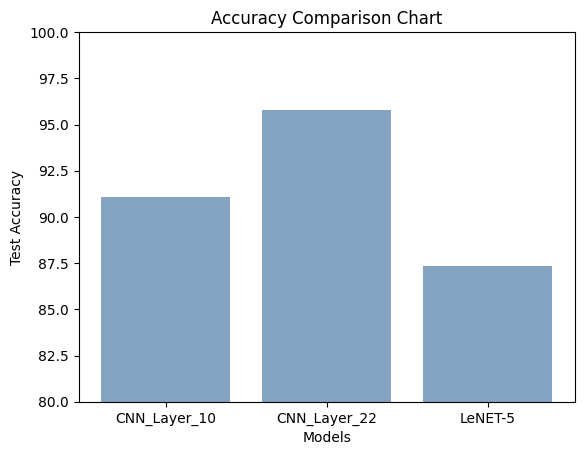

In [20]:
fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# langs = ['C', 'C++', 'Java', 'Python', 'PHP']
# students = [23,17,35,29,12]

plt.bar(Accuracy.keys(),Accuracy.values(),color=[0.2,0.4,0.6,0.6])
plt.title('Accuracy Comparison Chart')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
# plt.axes.set_title('Accuracy Comparison Chart')
# plt.axes.set_xlabel('Models')
# plt.set_ylabel('Test Accuracy')
# ax.set_yticklabels(np.arange(0,100))
plt.ylim(80,100)
plt.show()


In [21]:
fig.savefig('Comparison chart.jpeg')

In [22]:
def test_data():
    data=[]
    labels=[]
    imagePaths = list(paths.list_images("D:\Programming\HHCR testing\dataset_test"))
    for (i, imagePath) in enumerate(imagePaths):
        if os.path.exists(imagePath):
            image_gray = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image_gray, (img_height, img_width))
            label = imagePath.split(os.path.sep)[-2]
            data.append(image)
            labels.append(label)
        
    x_test=np.asarray(data)
    y_test=np.asarray(labels)
    x_test = x_test.reshape(x_test.shape[0], img_height, img_width, CHANNELS)
    
    x_test = x_test.astype('float32')
    x_test /= 255
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return x_test,y_test



In [74]:
def cnn_1_test():
    MODEL_NAME='CNN_Layer_10'
    model=load_model(f"out/{MODEL_NAME}-{BATCH_SIZE}-{EPOCHS}.h5")
    acc=accuracy(x,y,model)
    Accuracy[MODEL_NAME]=acc

def cnn_2_test():
    MODEL_NAME='CNN_Layer_22'
    model=load_model(f"out/{MODEL_NAME}-{BATCH_SIZE}-{EPOCHS}.h5")
    acc=accuracy(x,y,model)
    Accuracy[MODEL_NAME]=acc

def Lenetmodel_test():
    MODEL_NAME='LeNET-5'
    model=load_model(f"out/{MODEL_NAME}-{BATCH_SIZE}-{EPOCHS}.h5")
    acc=accuracy(x,y,model)
    Accuracy[MODEL_NAME]=acc

def ANN_model():
    MODEL_NAME='ANN'
    model=load_model(f"out/{MODEL_NAME}-{BATCH_SIZE}-{EPOCHS}.h5")
    acc=accuracy(x,y,model)
    Accuracy[MODEL_NAME]=acc    

In [70]:
# def main():
Accuracy=dict()

print("\n[INFO] loading data from the dataset into variables")
x, y= test_data()
cnn_1_test()
cnn_2_test()
Lenetmodel_test()
# ANN_model()


# if __name__ == '__main__':
#     main()


[INFO] loading data from the dataset into variables
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 32, 32, 6)         156       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 16, 16, 6)         0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 12, 12, 16)        2416      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 6, 6, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_14 (Flatten)        (None, 576)               0         
                                                                 


In [72]:
print(Accuracy)

{'LeNET-5': 79.375}


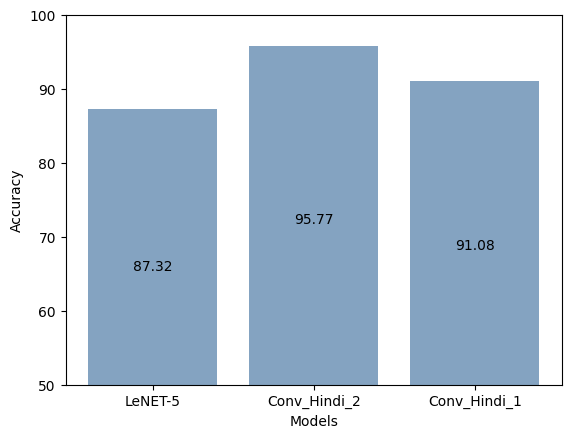

In [53]:
fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# langs = ['C', 'C++', 'Java', 'Python', 'PHP']
# students = [23,17,35,29,12]
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i]*0.75,f"{y[i]:0.2f}",ha='center')
plt.bar(Accuracy.keys(),Accuracy.values(),color=[0.2,0.4,0.6,0.6])
# plt.title('Testing Accuracy Comparison Chart')
plt.xlabel('Models')
plt.ylabel('Accuracy')
# plt.axes.set_title('Accuracy Comparison Chart')
# plt.axes.set_xlabel('Models')
# plt.set_ylabel('Test Accuracy')
# ax.set_yticklabels(np.arange(0,100))
addlabels(Accuracy.keys(),list(Accuracy.values()))
plt.ylim(50,100)
plt.show()


In [54]:
fig.savefig('Test data Comparison chart.jpeg')